In [2]:
import sys
sys.path.append('/kaggle/input/vae_structure/pytorch/vae_cifar_py/1')

import vae_cifar as vae_cifar
from torchvision import transforms, datasets
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = 'cuda'

BATCH_SIZE = 128
EPOCHS = 100
LR = 0.3*1e-3
N_LATENS = 512
BETA = 1

model = vae_cifar.ConvVAE((3, 32, 32), N_LATENS, BETA, device=device).to(device)
model.load_state_dict(torch.load('/kaggle/input/vae_cifar/pytorch/vae/1/conv_vae_cifar_more_layers_100.pth', map_location=device))

<All keys matched successfully>

In [42]:
print(model.decoder.modules)

<bound method Module.modules of ConvDecoder(
  (model): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): ResBlock(
      (func): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (residual): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ResBlock(
      (func): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2

In [56]:
activations_encoder = {
    'layer1' : None,
    'layer2' : None,
    'layer3' : None,
    'layer4' : None,
    'layer5': None
}

activations_decoder = {
    'layer1' : None,
    'layer2' : None,
    'layer3' : None,
    'layer4' : None,
    'layer5' : None,
}
# activations_encoder = {}
def get_activation_foo(name, activations):
    def hookFoo(model, input, output):
        # if activations[name] == None:
        activations[name] = output.detach()
        # else:
        #     activations[name] = torch.cat((activations[name], output.detach()), 0)
    return hookFoo

def get_activation_foo_input(name, activations):
    def hookFoo(model, input, output):
        # if activations[name] == None:
        activations[name] = input[0].detach()
        # else:
        #     activations[name] = torch.cat((activations[name], input[0].detach()), 0)
    return hookFoo

model.encoder.model[3].register_forward_hook(get_activation_foo('layer1', activations_encoder))
model.encoder.model[6].register_forward_hook(get_activation_foo('layer2', activations_encoder))
model.encoder.model[9].register_forward_hook(get_activation_foo('layer3', activations_encoder))
model.encoder.model[12].register_forward_hook(get_activation_foo('layer4', activations_encoder))
model.encoder.model[14].register_forward_hook(get_activation_foo('layer5', activations_encoder))

model.decoder.model[0].register_forward_hook(get_activation_foo_input('layer1', activations_decoder))
model.decoder.model[4].register_forward_hook(get_activation_foo_input('layer2', activations_decoder))
model.decoder.model[8].register_forward_hook(get_activation_foo_input('layer3', activations_decoder))
model.decoder.model[12].register_forward_hook(get_activation_foo_input('layer4', activations_decoder))
model.decoder.model[16].register_forward_hook(get_activation_foo_input('layer5', activations_decoder))

In [57]:
sys.path.append('/kaggle/input/smallness/pytorch/smallnet/1')

from smallnet import LinearNet, Net, split_dataset
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm

In [88]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images to [-1, 1]
])

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=transform)

train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [59]:
from torchvision.utils import make_grid
TITLE_FONT_SIZE = 16

def show_samples(
    samples,
    title,
    figsize=None,
    nrow=None,
) -> None:

    if isinstance(samples, np.ndarray):
        samples = torch.FloatTensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (5, 5)
    plt.figure(figsize=figsize, dpi=300)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(5,))
    images = data[idxs]
    show_samples(images, title)

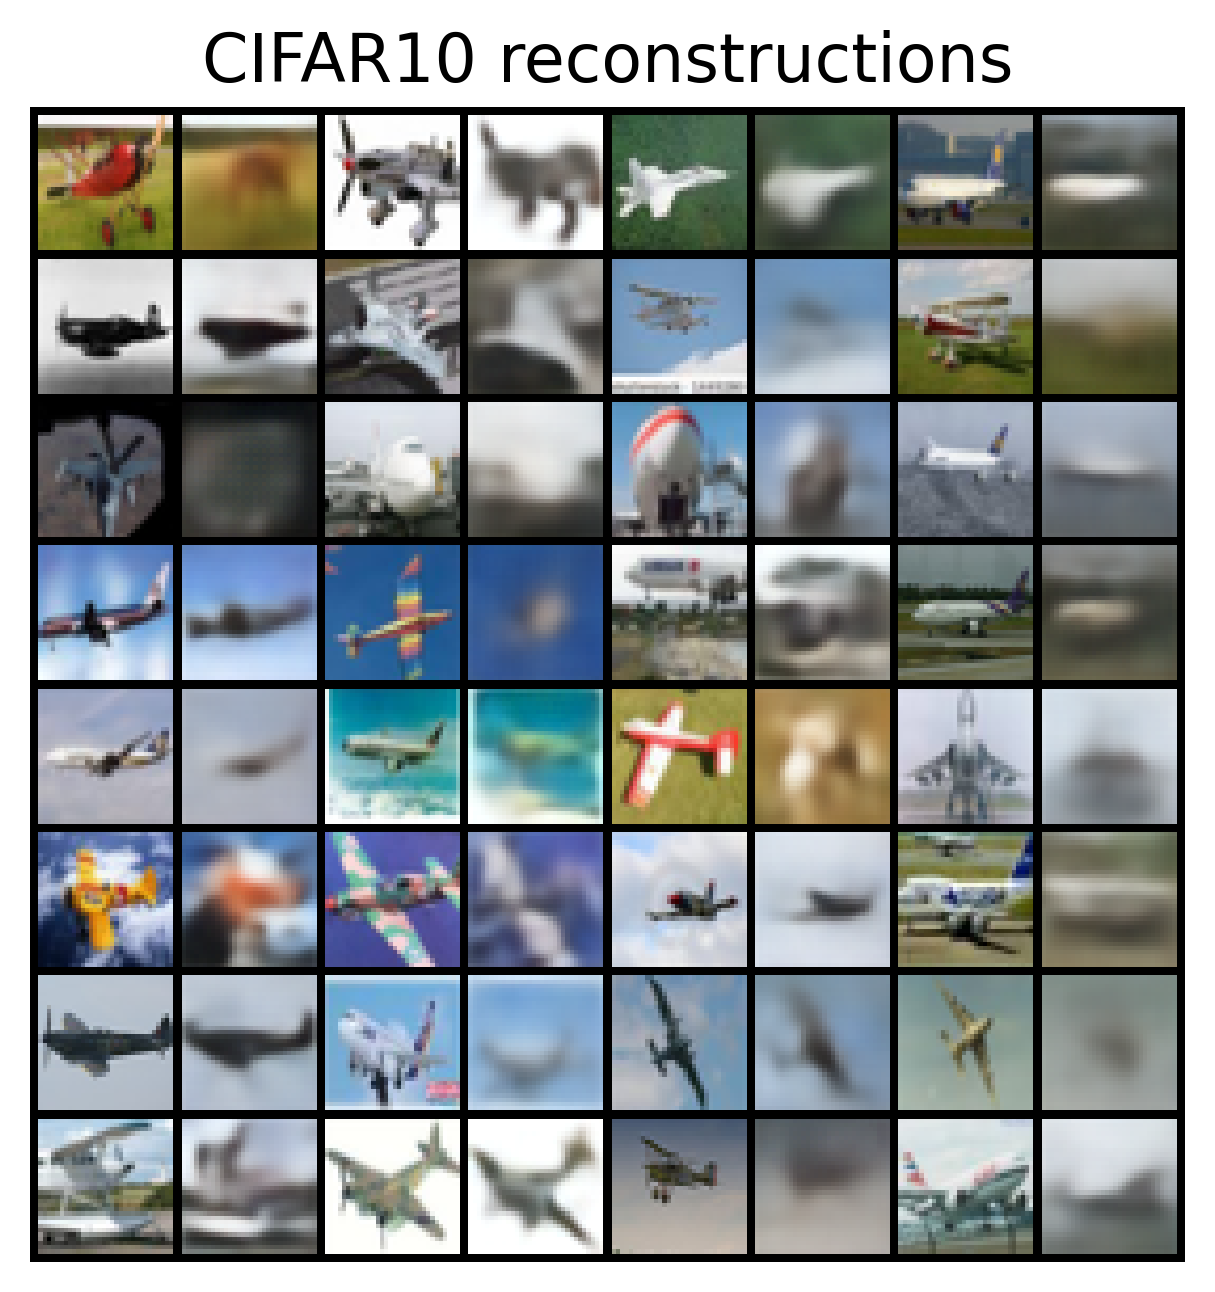

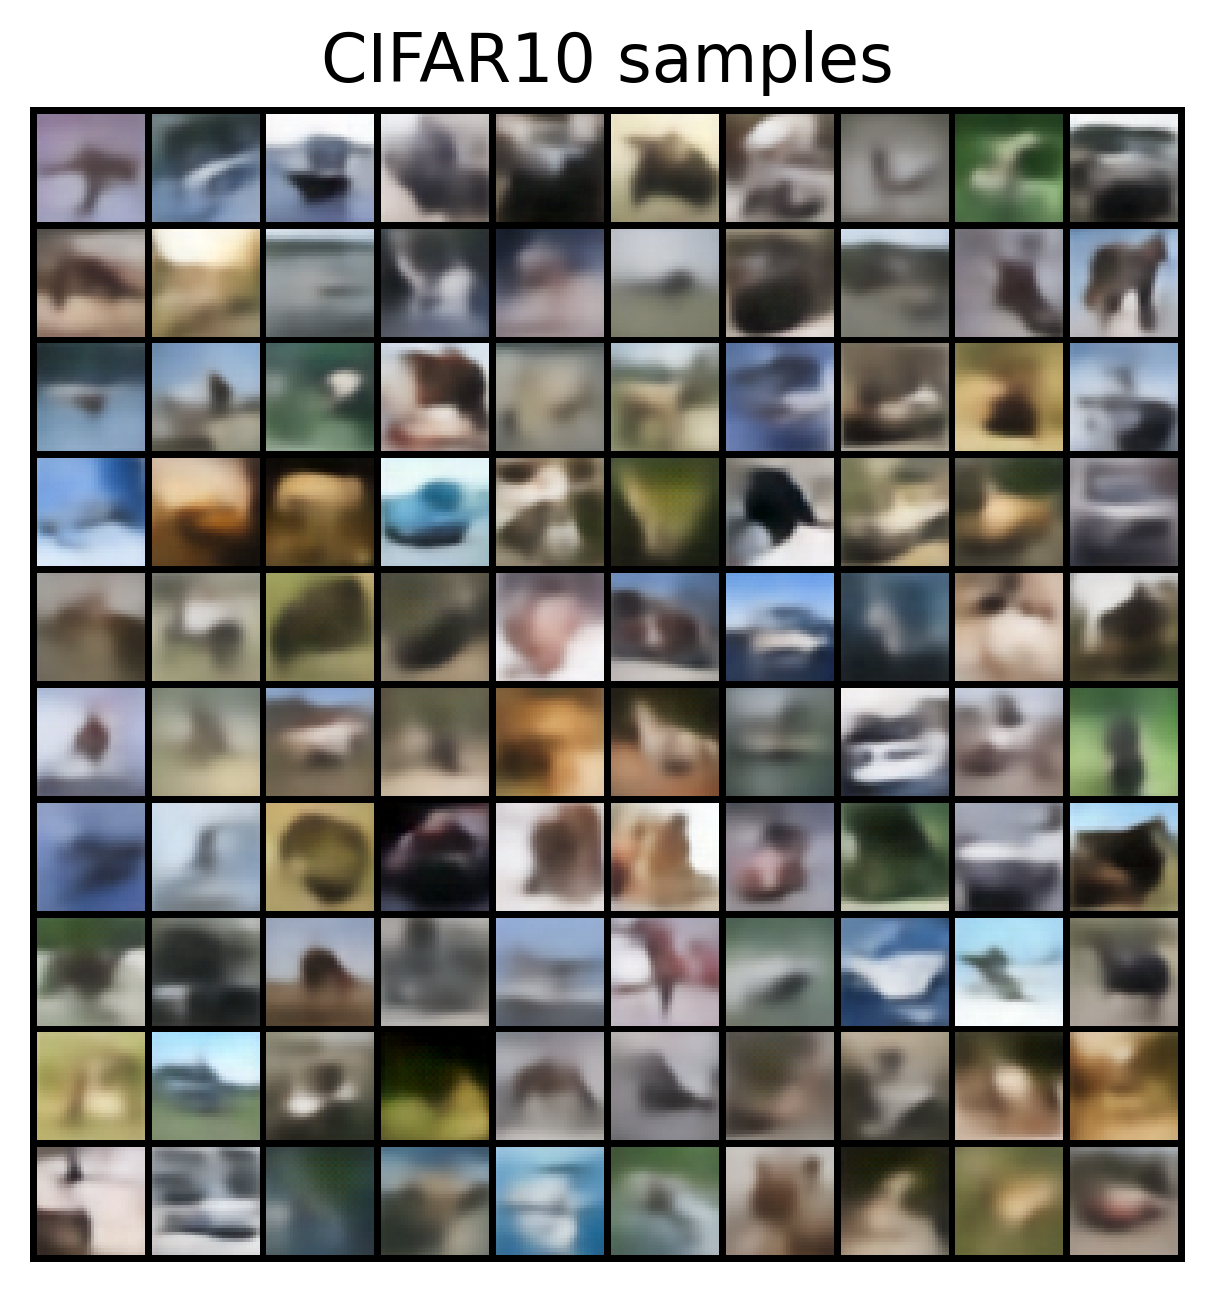

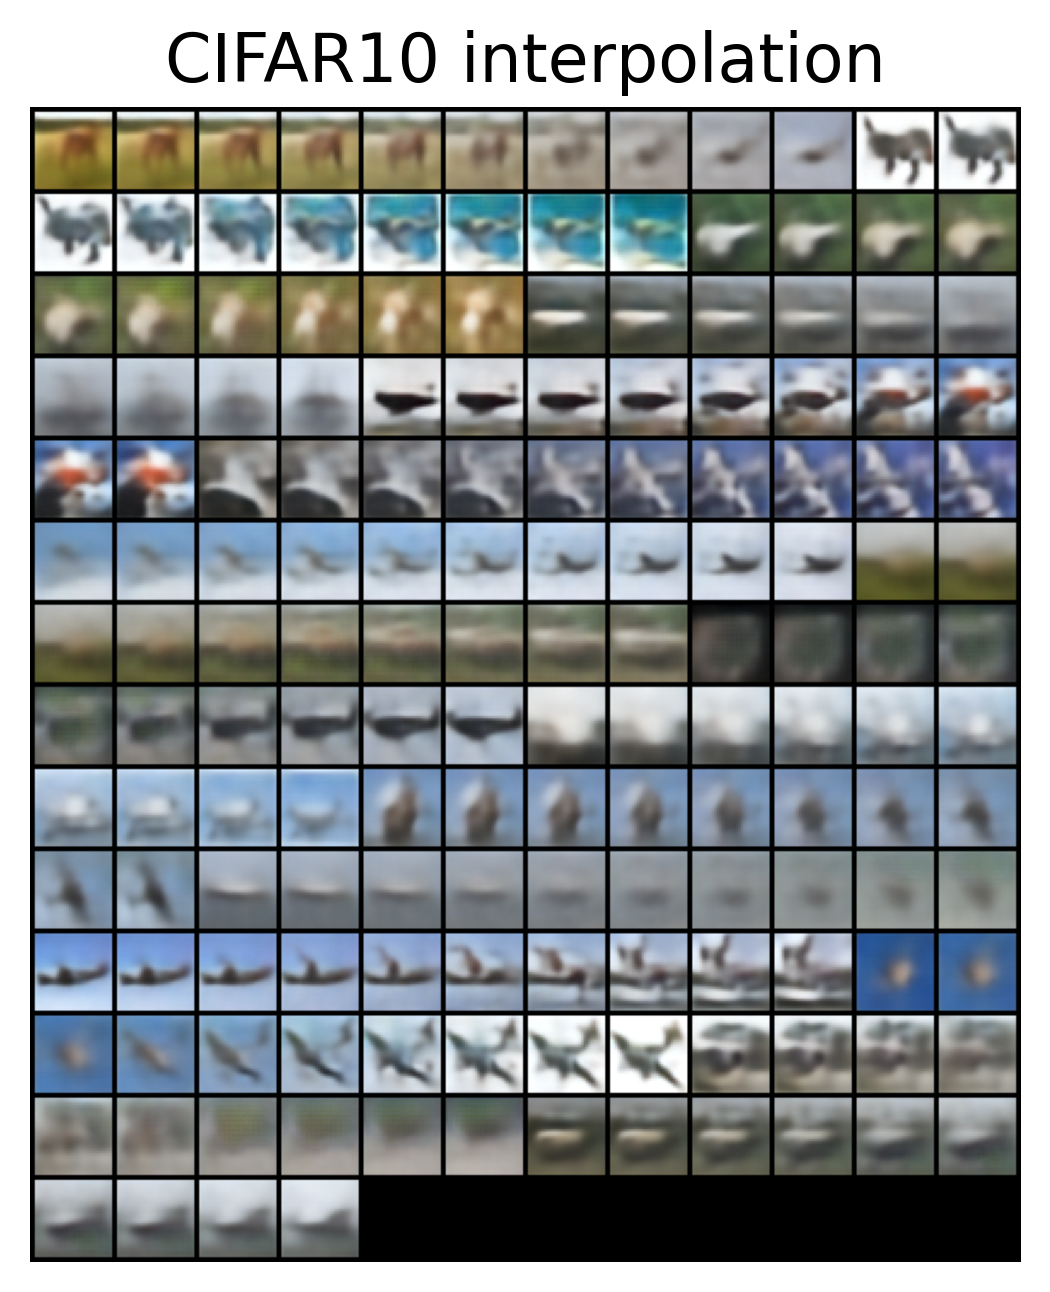

In [96]:
samples = model.sample(100)
USE_CUDA=True
x = next(iter(test_loader))[:50]
x = x[0]
# print(x.shape)
if USE_CUDA:
    x = x.to(device)

with torch.no_grad():
    z = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z[:, :N_LATENS]), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20]
x = x[0].to(device)
with torch.no_grad():
    z = model.encoder(x)
    z = z[:, :N_LATENS]
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'CIFAR10 reconstructions')
show_samples(samples, 'CIFAR10 samples')
show_samples(interps, 'CIFAR10 interpolation')

In [71]:
def transform_to_features(activations, batch_size):
    with torch.no_grad():
        feats = torch.Tensor([]).to(device)
        for key in activations.keys():
            val = activations[key]
            cur_feat = val[-batch_size:]
            if len(val.shape) == 4:
                cur_feat = val[-batch_size:].mean(dim=[2,3])
            feats = torch.cat((feats, cur_feat), dim=1)
            activations[key] = None
        torch.cuda.empty_cache()
    return feats

In [72]:
def train_model(train_loader, model, criterion, optimizer, model_vae, activations, epochs=90, loss_list=[], device='mps'):
    if activations == 'encoder':
      activations = activations_encoder
    elif activations == 'decoder':
      activations = activations_decoder

    model.train()
    loss_list = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # print(images.shape)
            with torch.no_grad():
                model_vae(images)
            # print(activations_decoder['layer1'].shape)
            if activations != 'mix':
              features_enc = transform_to_features(activations, labels.shape[0])
            else:
              features_enc = transform_to_features(activations_encoder, labels.shape[0])
              features_dec = transform_to_features(activations_decoder, labels.shape[0])
              features_enc = torch.cat((features_enc, features_dec), dim=1)

            # print(features_enc)
            features_enc = features_enc.to(device)
            outputs = model(features_enc)
            optimizer.zero_grad()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        loss_list.append(running_loss / len(train_loader))
#         print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    return loss_list


def test_model(model, test_loader, model_vae, activations, device='mps'):
    if activations == 'encoder':
      activations = activations_encoder
    elif activations == 'decoder':
      activations = activations_decoder

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                model_vae(images)
            if activations != 'mix':
              features_enc = transform_to_features(activations, labels.shape[0])
            else:
              features_enc = transform_to_features(activations_encoder, labels.shape[0])
              features_dec = transform_to_features(activations_decoder, labels.shape[0])
              features_enc = torch.cat((features_enc, features_dec), dim=1)

            features_enc.to(device)

            outputs = model(features_enc)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")
    return accuracy

In [73]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch
import numpy as np
from smallnet import LinearNet, Net, split_dataset

In [97]:
transform_to_features(activations_decoder, 30).shape

torch.Size([16, 992])

In [75]:
samples = model.sample(100)
USE_CUDA=True
x = next(iter(test_loader))[:50]
x = x[0]
# print(x.shape)
if USE_CUDA:
    x = x.to(device)

with torch.no_grad():
    z = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z[:, :N_LATENS]), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()
reconstructions.shape

(64, 3, 32, 32)

In [76]:
def split(dataset, num_train_per_class, num_test_per_class):
    train_indices = []
    test_indices = []
    for i in range(10):
        # print(torch.tensor(dataset.targets) == i)
        indices = torch.where(torch.tensor(dataset.targets) == i)[0].tolist()
        train_indices.extend(indices[:num_train_per_class])
        test_indices.extend(indices[num_train_per_class:num_train_per_class+num_test_per_class])
    return train_indices, test_indices


In [77]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images to [-1, 1]
])

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=transform)

train_indices, test_indices = split(train_dataset, num_train_per_class=64, num_test_per_class=64)

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(train_dataset, test_indices)
# print(train_subset)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32)

Files already downloaded and verified


In [89]:
input_size = 992 + 1504
num_classes = 10

linModel = Net(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linModel.parameters(), lr=0.001)

linModel.to(device)

train_model(train_loader, linModel, criterion, optimizer, model, activations='mix', epochs=90, loss_list=[], device=device);

100%|██████████| 90/90 [41:14<00:00, 27.49s/it]


In [90]:
test_model(linModel, test_loader, model, activations='mix', device=device)

Accuracy: 56.8%


56.8

In [98]:
enc_accuracy_diff_size = []
for train_size in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    train_indices, test_indices = split(train_dataset, num_train_per_class=train_size, num_test_per_class=64)

    train_subset = Subset(train_dataset, train_indices)
    test_subset = Subset(train_dataset, test_indices)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32)

    input_size = 992
    num_classes = 10

    linModel = Net(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(linModel.parameters(), lr=0.001)

    model.to(device)

    train_model(train_loader, linModel, criterion, optimizer, model, activations='decoder', epochs=90, loss_list=[], device=device);
    # torch.save(model.state_dict(), f'smallnet-Net-{train_size}.pth')


    enc_accuracy_diff_size.append(test_model(linModel, test_loader, model, activations='decoder', device=device))

100%|██████████| 90/90 [00:01<00:00, 51.79it/s]


Accuracy: 19.53125%


100%|██████████| 90/90 [00:03<00:00, 25.64it/s]


Accuracy: 20.0%


100%|██████████| 90/90 [00:05<00:00, 15.10it/s]


Accuracy: 21.25%


100%|██████████| 90/90 [00:10<00:00,  8.55it/s]


Accuracy: 22.96875%


100%|██████████| 90/90 [00:20<00:00,  4.36it/s]


Accuracy: 23.90625%


100%|██████████| 90/90 [00:40<00:00,  2.20it/s]


Accuracy: 22.96875%


100%|██████████| 90/90 [01:22<00:00,  1.09it/s]


Accuracy: 26.40625%


100%|██████████| 90/90 [02:44<00:00,  1.82s/it]


Accuracy: 27.96875%


100%|██████████| 90/90 [05:30<00:00,  3.68s/it]


Accuracy: 30.3125%


100%|██████████| 90/90 [10:56<00:00,  7.30s/it]


Accuracy: 31.71875%


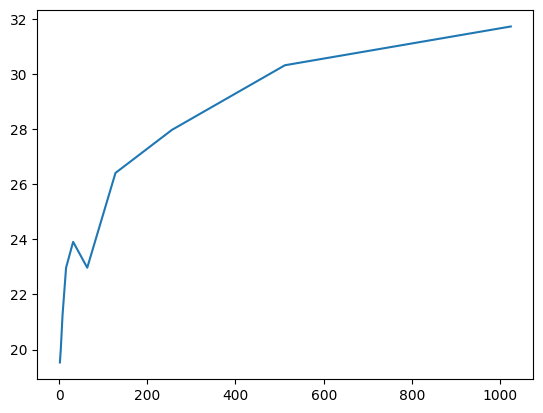

In [99]:
plt.plot([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], enc_accuracy_diff_size)

In [100]:
enc_accuracy_diff_size

[19.53125,
 20.0,
 21.25,
 22.96875,
 23.90625,
 22.96875,
 26.40625,
 27.96875,
 30.3125,
 31.71875]